# L6: Exercise: Data Augmentation

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

import pandas as pd

In [4]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'C:/Amin/Workspace/Data/Kaggle/Computer Vision/archive/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'C:/Amin/Workspace/Data/Kaggle/Computer Vision/archive/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


Explore Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


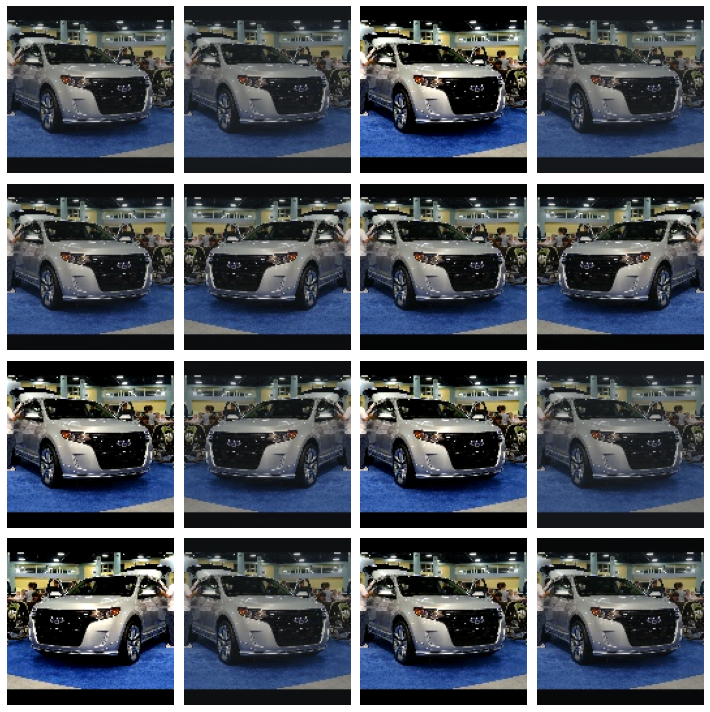

In [6]:
augment = keras.Sequential([
    preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [2]:
# test preprocessing.RandomContrast for'citrus_leaves' data

# import tensorflow_datasets as tfds
# ds, meta = tfds.load('citrus_leaves', with_info=True, split='train', shuffle_files=True)

# set to fixed image size 256x256
PATH = "C:/Users/amina/tensorflow_datasets/downloads/extracted/ZIP.data.mend.com_publ-file_data_3f83_file_5339-6fl4bTSbE2puRTWeZKuryFdJbVkJsxOBFwfgyyipUZd8c/Citrus/Leaves"
ds = image_dataset_from_directory(PATH,
                                  validation_split=0.2, subset="training",
                                  image_size=(256,256), interpolation="bilinear",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)

Found 609 files belonging to 5 classes.
Using 488 files for training.


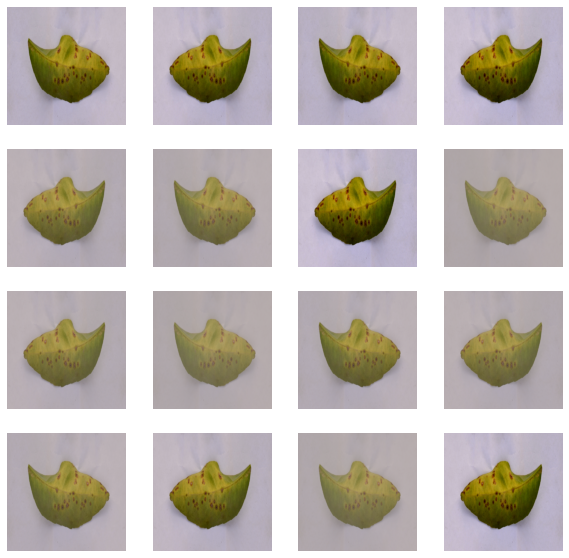

In [3]:
augment = keras.Sequential([
    preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

ex = next(iter(ds.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image).numpy().astype("uint8")) # , cmap="Greys"
    plt.axis('off')
plt.show()

In [8]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [9]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [10]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

Epoch 1/50
80/80 [==============================] - 64s 662ms/step - loss: 0.6777 - binary_accuracy: 0.5822 - val_loss: 0.6533 - val_binary_accuracy: 0.5783
Epoch 2/50
80/80 [==============================] - 41s 509ms/step - loss: 0.6659 - binary_accuracy: 0.5785 - val_loss: 0.6556 - val_binary_accuracy: 0.5785
Epoch 3/50
80/80 [==============================] - 41s 510ms/step - loss: 0.6459 - binary_accuracy: 0.5921 - val_loss: 0.6189 - val_binary_accuracy: 0.6591
Epoch 4/50
80/80 [==============================] - 40s 500ms/step - loss: 0.6141 - binary_accuracy: 0.6736 - val_loss: 0.5982 - val_binary_accuracy: 0.6915
Epoch 5/50
80/80 [==============================] - 40s 497ms/step - loss: 0.6055 - binary_accuracy: 0.6959 - val_loss: 0.5900 - val_binary_accuracy: 0.6983
Epoch 6/50
80/80 [==============================] - 42s 526ms/step - loss: 0.5903 - binary_accuracy: 0.7057 - val_loss: 0.5950 - val_binary_accuracy: 0.7169
Epoch 7/50
80/80 [==============================] - 40s 50

80/80 [==============================] - 40s 496ms/step - loss: 0.0767 - binary_accuracy: 0.9711 - val_loss: 0.2670 - val_binary_accuracy: 0.9180
Epoch 47/50
80/80 [==============================] - 39s 492ms/step - loss: 0.0676 - binary_accuracy: 0.9742 - val_loss: 0.3001 - val_binary_accuracy: 0.9103
Epoch 48/50
80/80 [==============================] - 40s 497ms/step - loss: 0.0752 - binary_accuracy: 0.9726 - val_loss: 0.2606 - val_binary_accuracy: 0.9161
Epoch 49/50
80/80 [==============================] - 42s 521ms/step - loss: 0.0733 - binary_accuracy: 0.9730 - val_loss: 0.3822 - val_binary_accuracy: 0.8986
Epoch 50/50
80/80 [==============================] - 40s 503ms/step - loss: 0.0846 - binary_accuracy: 0.9695 - val_loss: 0.3545 - val_binary_accuracy: 0.9071


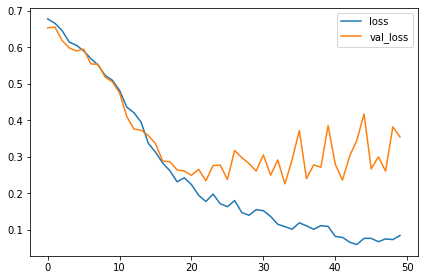

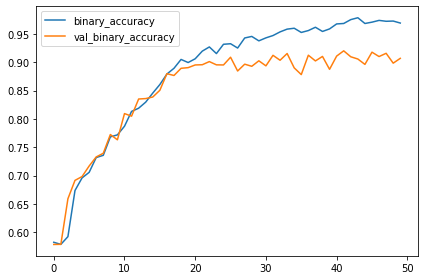

In [11]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();